# Metric validation on synthetic seismogram and noise

Metric compuation procedure is described in [Metric for evaluating difference between seismograms](./Metrics_study_intro.ipynb)

In [1]:
import sys
sys.path.append('..')

from functools import reduce

import numpy as np
from scipy import signal

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot

from utils import get_cv, draw_modifications_dist, get_modifications_list

## Load and investigate data

In [2]:
base_path = '/datasets/synthetics3/'
      
paths = dict(ideal = 'geo05_computedReflection_i.sgy',
             noise = 'geo_07_SurWaveNoise.sgy',)


In [3]:
field_index = reduce(lambda x, y: x.merge(y),
                     (FieldIndex(name=p, path=base_path+paths[p], extra_headers=['offset']) for p in paths))

len(field_index)

1

In [4]:
field_index._idf['offset'] = field_index._idf['offset'].abs()
field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,ideal,ideal,noise,noise
FieldRecord,,,,,,
1,1000,1,1,/home/antonina/winhome/datasets/synthtics3/geo...,1,/home/antonina/winhome/datasets/synthtics3/geo...
1,975,2,2,/home/antonina/winhome/datasets/synthtics3/geo...,2,/home/antonina/winhome/datasets/synthtics3/geo...
1,950,3,3,/home/antonina/winhome/datasets/synthtics3/geo...,3,/home/antonina/winhome/datasets/synthtics3/geo...
1,925,4,4,/home/antonina/winhome/datasets/synthtics3/geo...,4,/home/antonina/winhome/datasets/synthtics3/geo...
1,900,5,5,/home/antonina/winhome/datasets/synthtics3/geo...,5,/home/antonina/winhome/datasets/synthtics3/geo...


In [5]:
components = tuple(paths.keys())
batch = (Dataset(field_index, SeismicBatch).next_batch(1)
         .load(fmt='segy', components=components)
         .sort_traces(src=components, dst=components, sort_by='offset'))

In [6]:
ideal, noise = batch.ideal[0], batch.noise[0]
cv = get_cv([ideal])
cv

21.293914794921875

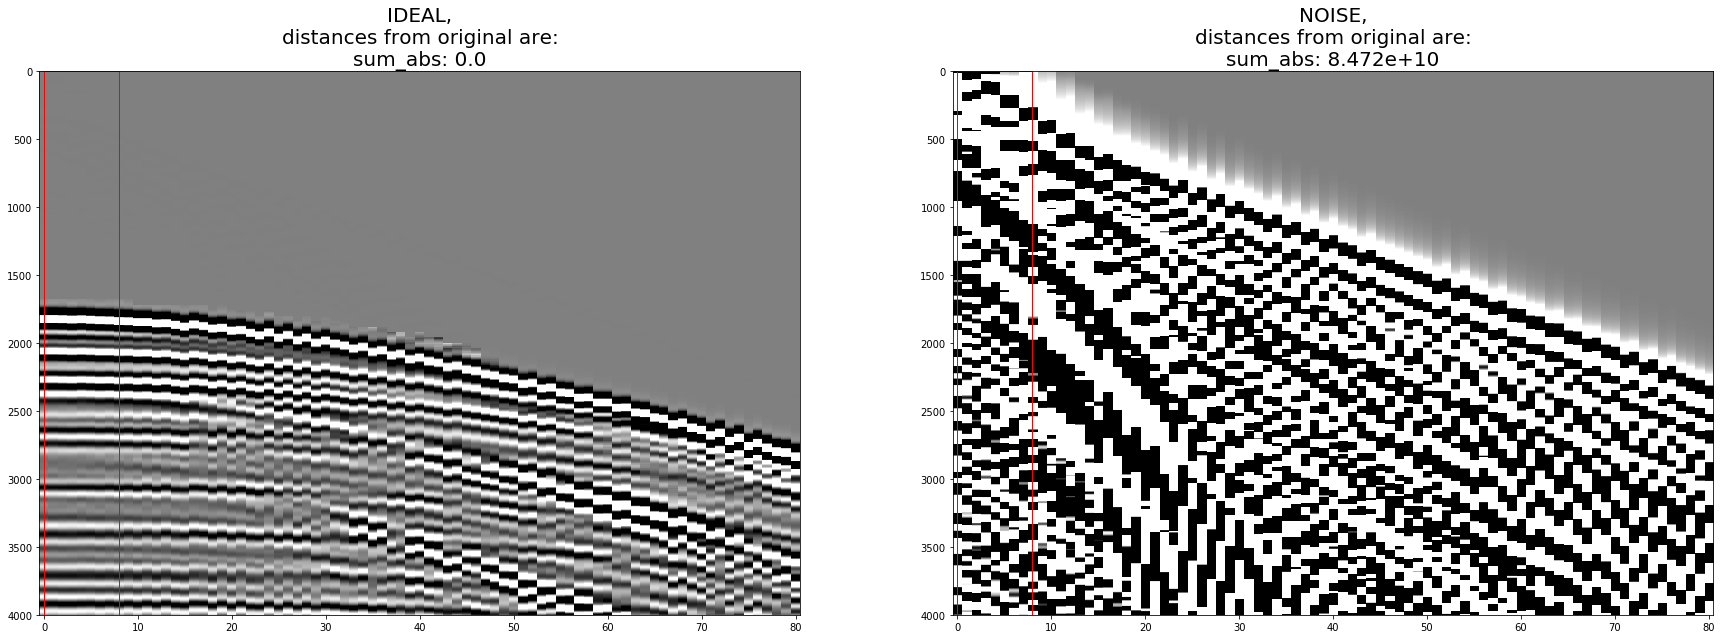

In [7]:
draw_modifications_dist(get_modifications_list(batch, 0), vmin=-cv, vmax=cv,  figsize=(30, 10), aspect='auto')

5271.6875


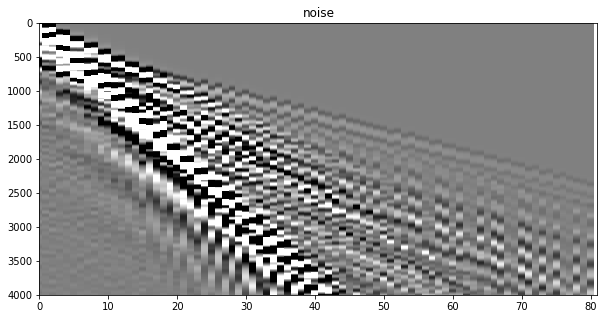

In [8]:
cv_n = get_cv([noise])
print(cv_n)
seismic_plot((noise,), names=('noise',),  figsize=(10, 5), vmin=-cv_n, vmax=cv_n, cmap='gray')

# Normalise noise

Make 95% of noise amplitudes abolute values be less than 1

In [9]:
noise_n = noise/cv_n

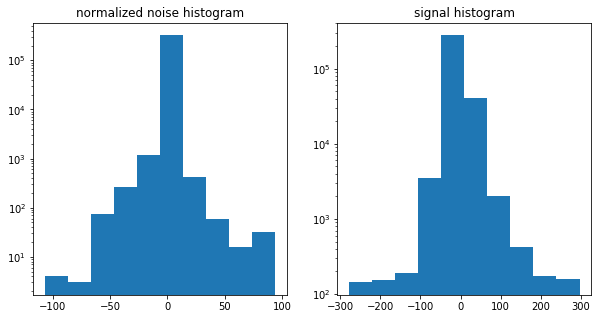

In [10]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].hist(noise_n.flatten())
axs[0].set_yscale('log')
axs[0].set_title('normalized noise histogram')

axs[1].hist((ideal).flatten())
axs[1].set_yscale('log')
axs[1].set_title('signal histogram');

# Calculate Metrics 

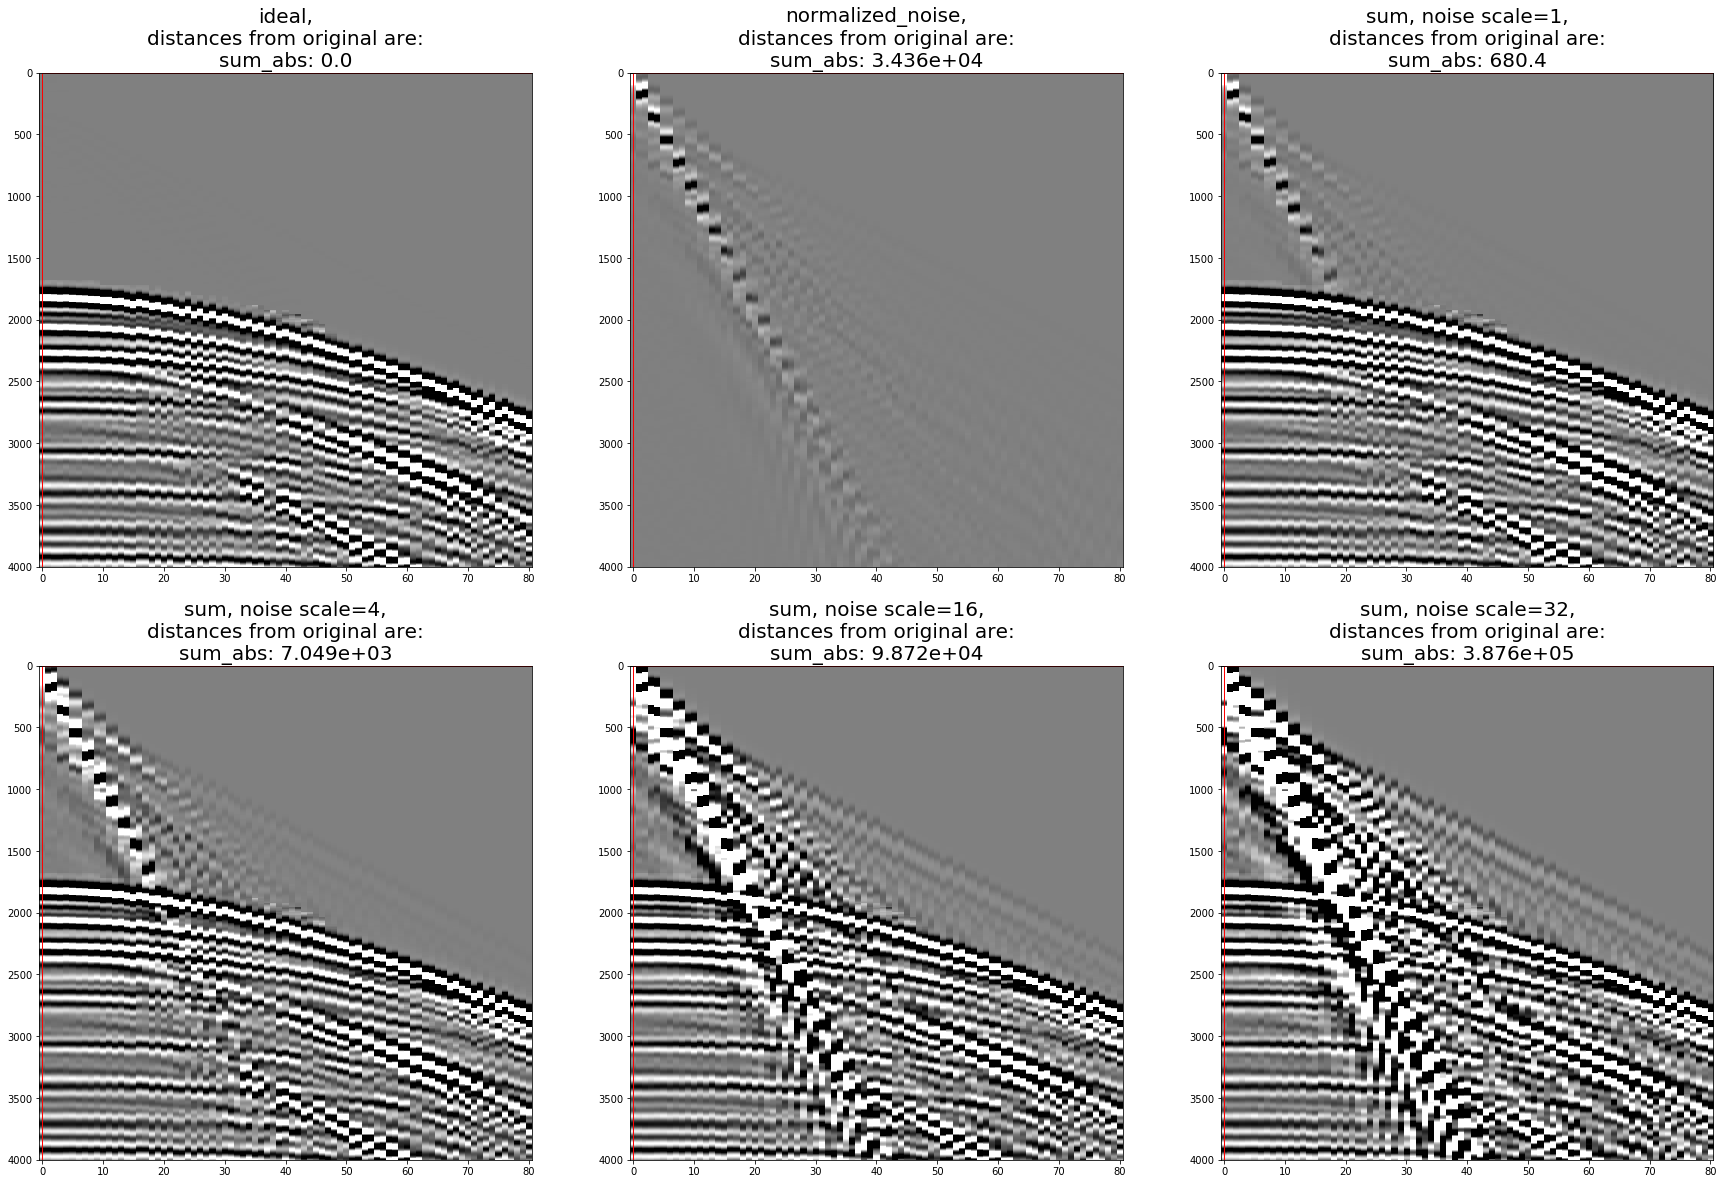

In [11]:
mods = [(ideal, 'ideal'), (noise_n, 'normalized_noise')]

for i in (1, 4, 16, 32):
    mods.append((ideal + noise_n * i, "sum, noise scale={}".format(i)))


draw_modifications_dist(mods, traces_frac=1, vmin=-cv, vmax=cv,  figsize=(30, 20), n_cols=3, aspect='auto')